<h1 align=center>Проект для «Викишоп»</h1>

<h2>Описание проекта:</h2>
<br>
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
<h2>Задача:</h2>
<br>
Обучить модель классифицировать комментарии на позитивные и негативные
<h2>Требование:</h2>
<br>
Постройть модель со значением метрики качества <b>F1 не меньше 0.75</b> 

## Содержание:
* [Предобработка данных](#preprocessing)
* [Модели](#models)
    * [Логистическая регрессия](#logreg)
    * [Наивный Байес](#bayes)
    * [Ансамбль](#ensemmble)
    * [Градиентный бустинг](#boost)
* [Тест](#test)
* [Заключение](#final)

In [84]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
import gc
'---------------------------------------'
'---------------------------------------'
plt.rcParams['figure.figsize'] = (10,8)
color = sns.color_palette("Paired")
plt.style.use('ggplot')
'---------------------------------------'
'---------------------------------------'
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
'---------------------------------------'
'---------------------------------------'
import catboost
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOP_WORDS = set(stopwords.words('english'))

RS = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cripe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cripe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cripe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
try:
    import optuna
except ModuleNotFoundError:
    print('Установка Optuna')
    !pip install optuna


try:
    import spacy
    spacy.prefer_gpu()
except ModuleNotFoundError:
    print('Установка Spacy')
    !pip install -U pip setuptools wheel
    !pip install -U spacy[cuda-autodetect]
    !python -m spacy download en_core_web_sm
    import spacy
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [7]:
try:
    import wordcloud
except ModuleNotFoundError:
    print('Установка wordcloud')
    !pip install wordcloud
    import wordcloud

## Предобработка данных <a class="anchor" id="preprocessing"></a>

In [9]:
#уберем первую колонку
data = data.drop('Unnamed: 0', axis=1)

In [10]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


<h4 align=center>Такими словами нас встречает проект</h4>

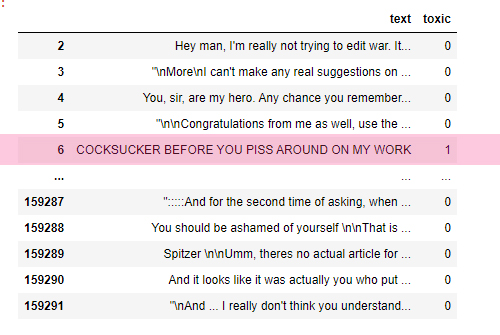

Стоит оценить количество токсичных сообщений

In [11]:
#подсчитаем количество
common, toxic = data['toxic'].value_counts().to_dict().values()

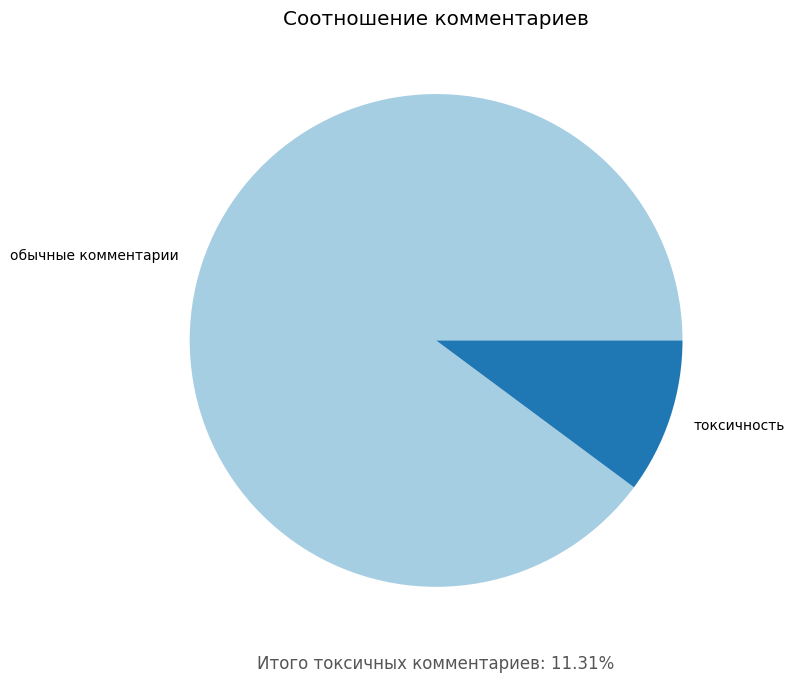

In [12]:
#посмотрим соотношение
plt.pie(x=[common, toxic], labels=['обычные комментарии', 'токсичность'], colors=color)
plt.title('Соотношение комментариев')
plt.xlabel(f'Итого токсичных комментариев: {round(toxic*100/common, 2)}%')
plt.show()

Еще не все потеряно, хотя почти каждый 10 человек - токсичит. Нам упростили задание, мы должны определить только токичность, без учета абьюзинга, расизма, гомофобии и прочего. Начнем

### Чистим текст

Как мы можем увидеть ниже, текст содержит большое количество знаков препинания,смайлики, знаки переноса строки, а также разный регистр слов. Исправим это

In [13]:
#до
data.sample(10)

,text,toxic
63572,"""\nThank you (talk) Please {{re}} """,0
7057,"YouTube Network's Requesting an Article, Revie...",0
11130,"""\nHow can you say """"it doesn't say X"""", when ...",0
122819,Illicit Use Slang Terms \n\nI am thinking thi...,0
122146,"""\n\nYes, this is my best answer. If you re-re...",0
23129,can go after a brand then I feel bad for you; ...,0
14430,"Oh, that can surely be done.. but this discuss...",0
28804,"""\nWelcome\n\nHello and welcome to Wikipedia! ...",0
72533,"""\n\nSpeedy deletion of Hauffe\n A tag has bee...",0
120228,"Just a few paragraphs above yours, Steel buste...",0


In [14]:
def get_clean_text(string:str, without_dots=True, to_lower=True):
    """
    :::Принимаем строку с инфомрационным мусором
    :::Если without_dots - удаляем точки
    :::Возвращаем строку
    
    Example:
    to: '""\n\n Infobox 34 island(s) \n\nPlease revert your...'
    from: 'infobox 34 islands please revert your'
    """
    #шаблон для удаления знаков препинания
    if without_dots:
        pattern = r'[\.\,\!\?\:\;\@\"\%\&\#\=\-\_\+\(\)]'
        x = re.subn(pattern, ' ', string)
    else:
        pattern = r'[\,\!\?\:\;\@\"\%\&\#\=\-\_\+\(\)]'
        x = re.subn(pattern, ' ', string)
        x = re.subn(r'[\.]{2,}', ' ', x[0])
    #заменяет апостроф, чтобы сохнарить как артикль, но убрать как скобки
    #cant - бро, 'cant' - не бро
    x = re.subn(r"[\']", '', x[0])
    #удаляем табуляцию и перенос строки
    string = x[0].strip().replace('\n', ' ').replace('\t', ' ').split()
    
    #избавляемся от лишних пробелов
    string = ' '.join(string)
    
    #приводим к lowercase, если требуется
    if to_lower:
        string = string.lower()
    
    return string

In [15]:
#сохраним датасет для других моделей
clean_data = data.copy()
#применяем функцию, без точек
clean_data['text'] = clean_data['text'].apply(lambda x: get_clean_text(x, without_dots=True))

In [16]:
#как говорят индусы "this is before and this is after"
clean_data

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159287,and for the second time of asking when your vi...,0
159288,you should be ashamed of yourself that is a ho...,0
159289,spitzer umm theres no actual article for prost...,0
159290,and it looks like it was actually you who put ...,0


In [17]:
#насколько длинны комментарии
length = [len(i.split()) for i in clean_data['text']]

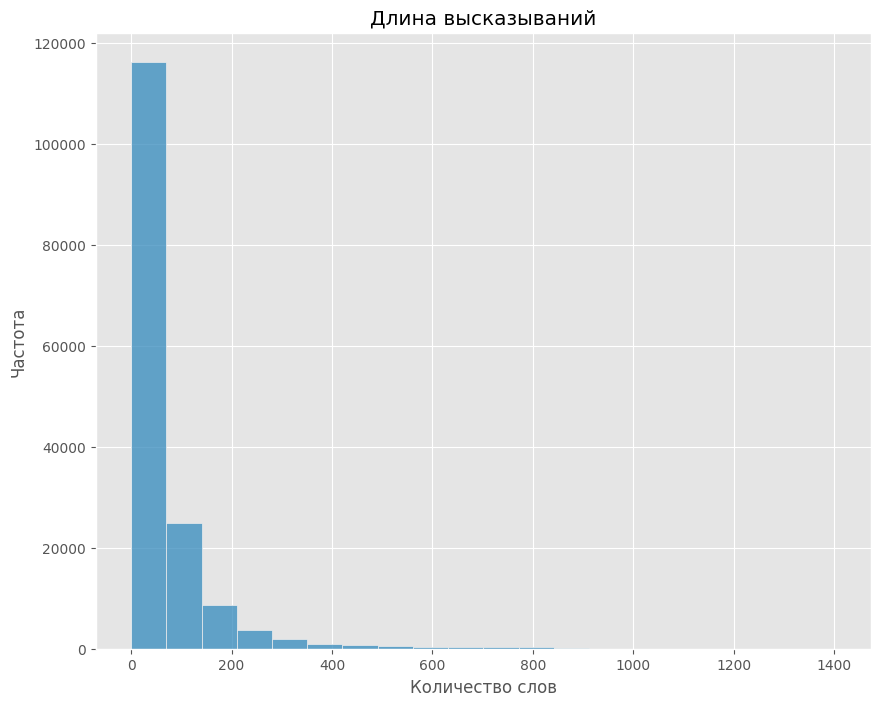

In [18]:
sns.histplot(length, bins=20)
plt.title('Длина высказываний')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

Экспоненциальное распределение с тяжелым хвостом

In [19]:
#комбо для графика
for_fun = pd.DataFrame(data={
    'length': length,
    'toxic': data['toxic']
})

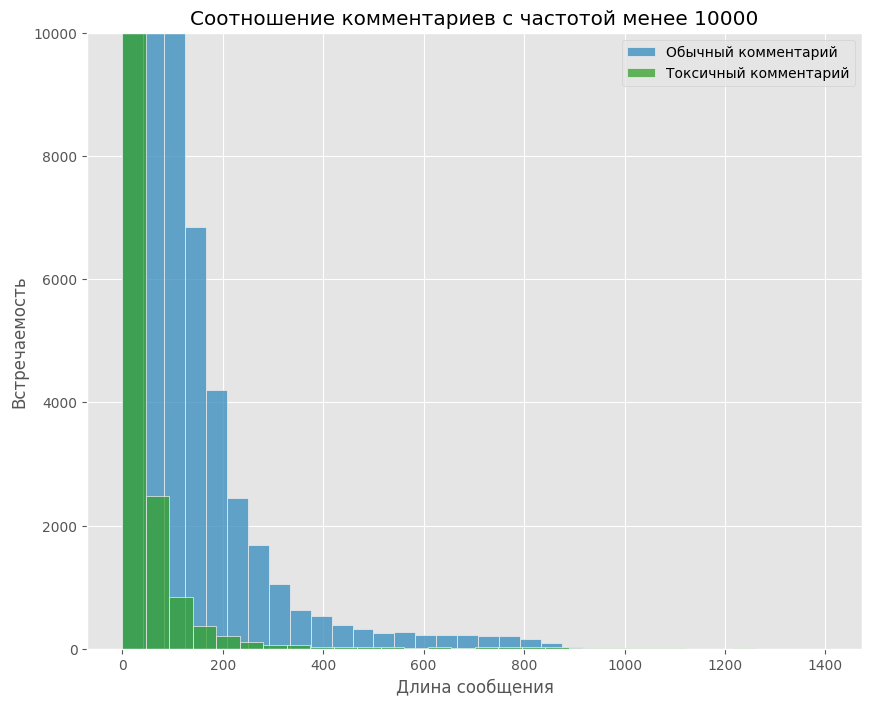

In [20]:
#график
sns.histplot(data=for_fun.loc[for_fun['toxic'] == 0, 'length'], bins=30)
sns.histplot(data=for_fun.loc[for_fun['toxic'] == 1, 'length'], color=color[3], bins=30)
plt.ylim(0, 10000)
plt.title('Соотношение комментариев с частотой менее 10000')
plt.legend(labels=['Обычный комментарий', 'Токсичный комментарий'])
plt.xlabel('Длина сообщения')
plt.ylabel('Встречаемость')
plt.show()

Токсичность любит лаконичность: адекватные комментарии содержат большее число слов. Либо токсичность - писать без пробелов

### Лемматизация

Теперь приведем слово к дефолтному состоянию, т.е. к его лемме

Анализ чужого языка - достаточно сложная задача. Например, какова разница в слове play: 
- I was playing football last week - Я играл в футбол на прошлой неделе (обозначаем глагол)
- Take a playing card from the desk - Возьми игральную карту из колоды
- He plays a games - Он играет в игры

Одно слово меняет свою форму, сохраняя смысл. Лемматизация оставляет смысл и отбрасывает языковые изыски. Библиотека nltk не очень хороша в этом смысле: она не всегда переводит множественное к единственному, не меняет время, например was и be. Поэтому используем библиотеку Spacy

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def get_lemm_string(string:str, is_slow=True):
    """
    :::Принимает строку, возвращаем лемму каждого слова в строке
    :::Если is_slow, то применяем space, иначе - nltk
    :::Return: str
    Example:
    :::Flying birds in the clouds -> fly bird in the cloud
    """
    if is_slow:
        #инициализируем лемматизотор
        result = nlp(string)
        #проходимся и переводим в лемму каждый элемент
        result = ' '.join([word.lemma_ for word in result])
    else:
        #инициализируем лемматизотор
        lemmatizer = WordNetLemmatizer()
        #переводим в лемму
        result = lemmatizer.lemmatize(string)
    
    return result

In [22]:
#лемматизация spacy
clean_data['text'] = clean_data['text'].apply(lambda x:get_lemm_string(x, True))

In [24]:
#уберем два полученных Nan, по одному каждого класса
clean_data.dropna(inplace=True)

По правилам уже стоило разбить на трейт, валид и тест, но так как эту операцию все равно нужно выполнять для каждой подвыборки, то я решил провести сразу для всех, дабы миновать длительную процедуру

In [25]:
#Можем посмотреть, какие слова пишут чаще в обычных и токсичных комментах
#собираем в строку
positive = ' '.join(clean_data.loc[clean_data['toxic']==0, 'text'].tolist())
negative = ' '.join(clean_data.loc[clean_data['toxic']==1, 'text'].tolist())
#передаем в облако слов
pos_words = wordcloud.WordCloud(stopwords=STOP_WORDS, height=800, width=1000).generate(positive)
neg_words = wordcloud.WordCloud(stopwords=STOP_WORDS, height=800, width=1000).generate(negative)

In [26]:
#отражаем облако
def get_cloud(string, title='Комментарии'):
    plt.imshow(string)
    plt.title(title)
    plt.grid(None)

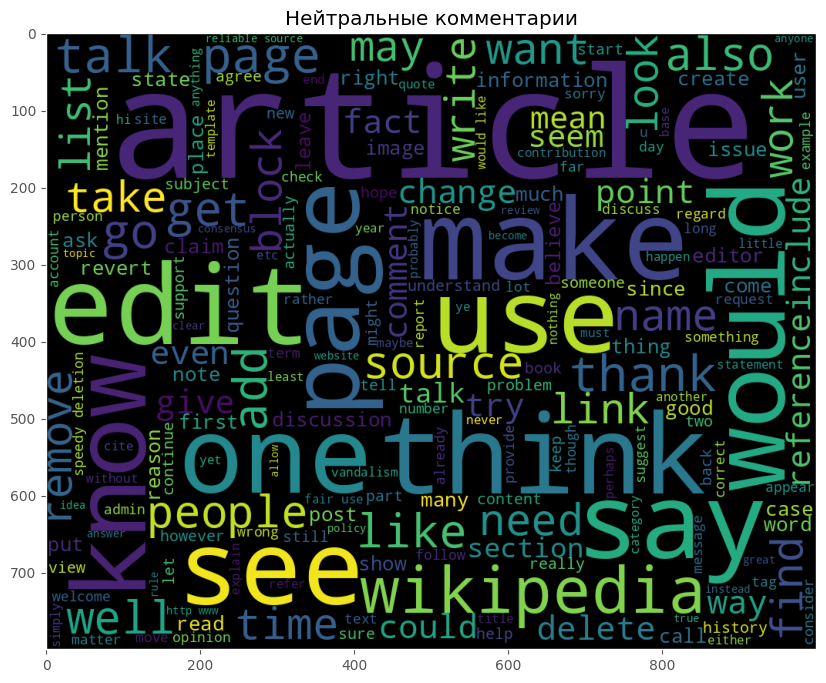

In [27]:
#для нейтральных
get_cloud(pos_words, 'Нейтральные комментарии')

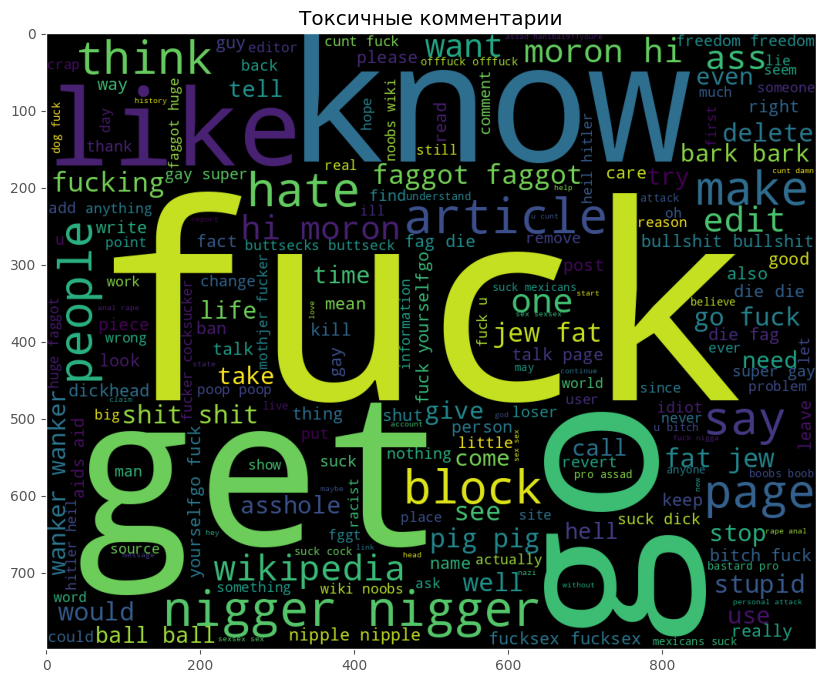

In [28]:
#негативные
get_cloud(neg_words, 'Токсичные комментарии')

Отвратительно, с чем приходится работать

Создаем функцию для разбиения на трейн, валидацию и тест

In [29]:
def get_split(data, target_name, test_size=0.1, is_stratify=True):
    #разбиваем на фичи и таргет
    X = data.drop(target_name, axis=1)
    y = data[target_name]
    #возвращаем подвыборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RS)
    
    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = get_split(clean_data, 'toxic', test_size=0.1, is_stratify=True)
#для валидации
temp = pd.concat((X_train, y_train), axis=1)
X_train, X_valid, y_train, y_valid = get_split(temp, 'toxic', test_size=0.1, is_stratify=True)

In [31]:
#проверка на разбиение
X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == clean_data.shape[0]

True

## Модели <a class="anchor" id="models"></a>

### Подготовка к моделям

Для моделей, неспособных работать с тестом, необходимо перевести текст в векторы. Есть два ~стула~ основных метода: CountVectorizer и TFITF. В чем разница? Слова вытягиваются в признаки(колонки), а каждая строка - миникорпус текста. На пересечении проставляются 0 и 1, 0 - если слово отсутствует в этой строке, 1 - если в наличии.

TFIDF - это "взвешивание" слова относительно предложения, где оно есть, и умноженное на десятичный логарифм его обратной встречаемости во всем корпусе.

Например, у нас 10 текстов, по 5 предложений, в каждом 100 слов. 
Слово "я" встречается. 5*100 - длина каждого подкорпуса. Если слово встретилось в данном подкорпусе 10 раз, то мы получаем 10/500=0.02. Всего такое слово встречается в каждом подкорпусе, которых у нас 10 штук. Тогда 10/10 = 1, логарифм равен 0. Получаем 0 * 0.02 = 0. Такой вес слова определяется его частой встречаемостью, потому он не будет нести важной информации. 

Если бы встречаемость было 10/4, то есть только в 4 подкорпусах, этот логарифм ~0.4 и вес слова составил бы 0.008

In [32]:
#определим веса
weight = dict(zip([0,1],compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)))
weight

{0: 0.5565505460945184, 1: 4.920823798627002}

In [33]:
#для быстрого ковертирвоания через корпус
def get_tfidf(corpus, data):
    return corpus.transform(data)

In [34]:
#переводим выборки
corpus = TfidfVectorizer(stop_words=STOP_WORDS, analyzer='word').fit(X_train['text'])
X_train_ti = get_tfidf(corpus, X_train['text'])
X_valid_ti = get_tfidf(corpus, X_valid['text'])

### Дамми

Сколько мы наберем, если все пометим нулями как доминантным значением?

In [82]:
dummy = f1_score(np.array([1]*data.shape[0]), data.iloc[:,-1])
print(f'Дамми F1: {dummy}')

Дамми F1: 0.0


Зато accuracу на высоте, любимая метркиа преподавателей с youtube

### Логистическая регрессия <a class="anchor" id="logreg"></a>

In [35]:
def log_reg(X, y, n_trials=10):
    """
    :::Функция подбирает оптимальные гиперпараметры на основе байесовского анализа
    :::Принимает признаки, таргет и количество испытаний
    """
    def objective(trial):
        #инициализируем параметры, а точнее наше априорное распределение параметров
        params = {
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag', 'saga']),
            'penalty': trial.suggest_categorical('penalty', ['l2', 'none']),
            'C': trial.suggest_float('C', 1.0, 10, step=0.5)      
        }
        #инициализируем модель
        model = LogisticRegression(**params, random_state=RS, class_weight=weight)
        #используем кросс-валидацию, которая будет балансировать тарег
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
        #проводим проверку по фолдам
        scores = cross_val_score(model, X, y, cv=skf, n_jobs=-1, error_score='raise', scoring='f1')
        #ыозвращаем лучший средний скор
        return np.mean(scores)
    
    #инициализируем байесовский оптимизатор
    study = optuna.create_study(direction='maximize')
    #передаем функцию для оптимизации и количество попыток
    study.optimize(objective, n_trials=n_trials)
    #возвращаем весь объект оптимизатора
    return study     

In [36]:
logreg = log_reg(X_train_ti, y_train)

In [37]:
#logreg.best_params
log_reg_params = {'solver': 'saga', 
                  'penalty': 'l2', 
                  'C': 6.0,
                 'class_weight': weight,
                 'random_state': RS}

In [38]:
#создадим словарь для собирания результатов скоров
#Имя модели: скор
result_scores = {}

In [39]:
#сделаем функцию для проверки на валидационном датасете
def get_valid_f1(model, x_t, x_v, y_t, y_v, model_name='Empty', proba=False):
    #обучаем
    model.fit(x_t, y_t)
    #предсказываем
    y_pred = model.predict(x_v)
    
    #если нужна вероятность
    if proba:
        return model.predict_proba(x_v)
    else:
        #замеряем
        f1 = np.round(f1_score(y_v, y_pred), 5)
        #измерим заодно и точность с полнотой
        precision = np.round(precision_score(y_v, y_pred), 5)
        recall = np.round(recall_score(y_v, y_pred), 5)
        #добавляем в словаь
        row = dict(zip(['f1', 'precision', 'recall'], [f1, precision, recall]))
        result_scores[model_name] = row
        print(f'Модель {model_name}, метрика F1 составляет {f1}')
        print(f'Модель {model_name}, метрика recall составляет {recall}')
        print(f'Модель {model_name}, метрика precision составляет {precision}')

In [40]:
#проверяем 
log_reg_model = LogisticRegression(**log_reg_params)

get_valid_f1(log_reg_model, X_train_ti, X_valid_ti, y_train, y_valid, model_name='Logistic Regression')

Модель Logistic Regression, метрика F1 составляет 0.76635
Модель Logistic Regression, метрика recall составляет 0.85655
Модель Logistic Regression, метрика precision составляет 0.69333


C:\Users\cripe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
#простая функция рисовать табличку
def get_metrics():
    pd.DataFrame(result_scores).plot(kind='bar', figsize=(8,5), color=color)
    plt.legend(loc=4)
    plt.title('Метрики')
    plt.ylabel('Шкала точности метрики')
    plt.show()

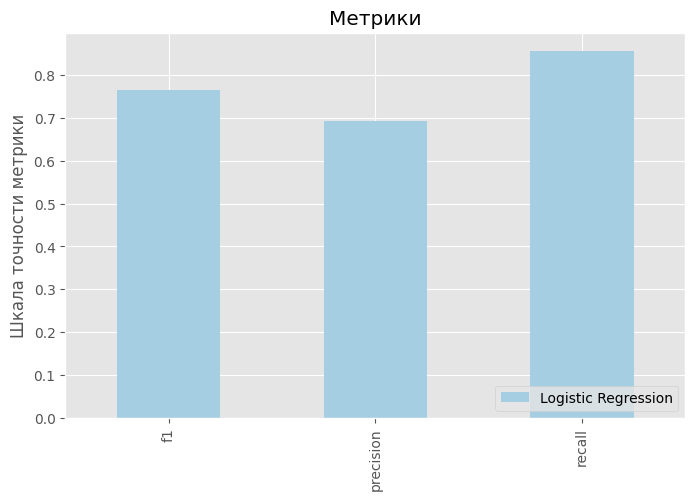

In [42]:
get_metrics()

С данной моделью мы смогли обнаружить почти 86% всех токсичных комментов, точно определены как токсичные - только 65%. Слабо

### Байес <a class="anchor" id="bayes"></a>

Данный классификатор отличается отличительной скоростью и неплохой точностью в бинарной и мультиклассификациях

In [43]:
#простая кросс-валидация для простой модели с минимумом гиперпараметров
def bayes_model(X,y):
    one = round(y.sum() / y.shape[0], 1)
    params = {
        'class_prior' : [1-one, one],
        'fit_prior': False,
        'alpha':False
    }
    model = MultinomialNB(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
    scores = cross_val_score(model, X, y, cv=skf, n_jobs=-1, error_score='raise', scoring='f1')
    print(f'Метрика Байеса: {round(np.mean(scores),5)}')
    return params

In [44]:
bayes_model_params = bayes_model(X_train_ti, y_train)

Метрика Байеса: 0.60171


In [45]:
bayes = MultinomialNB(**bayes_model_params)
get_valid_f1(bayes, X_train_ti, X_valid_ti, y_train, y_valid, model_name='MultinomialNB')

Модель MultinomialNB, метрика F1 составляет 0.62228
Модель MultinomialNB, метрика recall составляет 0.50034
Модель MultinomialNB, метрика precision составляет 0.8228


C:\Users\cripe\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


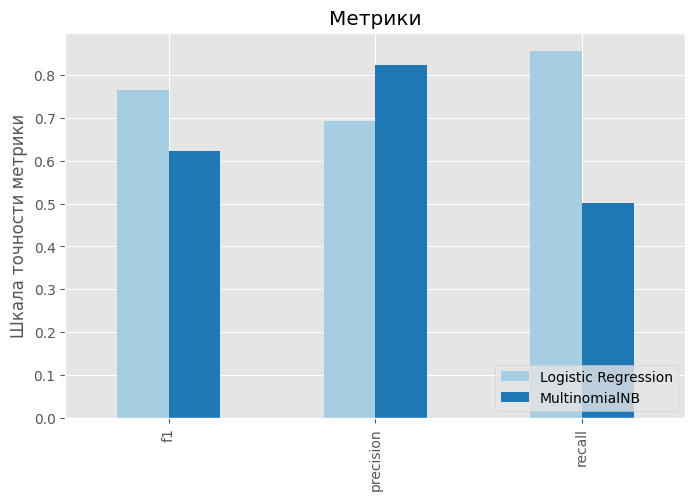

In [46]:
get_metrics()

In [47]:
pd.DataFrame(result_scores)

,Logistic Regression,MultinomialNB
f1,0.76635,0.62228
precision,0.69333,0.82280
recall,0.85655,0.50034


Здесь ситуация обратная: мы точно обнаружили 80% всех захваченных токсичных комментариев, вот только захватили таких комментариев только 48%. Можно ли улучшить предсказания, если сделать их ансамбль?

## Ансамбль <a class="anchor" id="ensemmble"></a>

In [48]:
#получаем вероятности
y_lr_prob = get_valid_f1(log_reg_model, X_train_ti, X_valid_ti, y_train, y_valid, proba=True)
y_nb_prob = get_valid_f1(bayes, X_train_ti, X_valid_ti, y_train, y_valid, proba=True)

C:\Users\cripe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\cripe\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Так как регрессия почти на всех метриках показала результаты лучше, то от нее будем брать 80%, а от байесовской модели будем брать 40%

In [49]:
#получим среднее
y_ensemble = (y_lr_prob*0.8+ y_nb_prob*0.4) / 2
#берем индекс большего числа
y_ensemble_prob = [np.argmax(i) for i in y_ensemble]

In [50]:
#добавим в таблицу через функцию
def get_metric_row(y_true, y_pred, model_name='Empty'):
    #наши метрики
    metrics = [f1_score(y_true, y_pred), 
               precision_score(y_true, y_pred), 
               recall_score(y_true, y_pred)]
    #создаем словарь
    row = dict(zip(['f1', 'precision', 'recall'], metrics))
    for k, v in row.items():
        print(f'Метрика {k}: {round(v, 5)}')
        
    #добавляем в общий словарт
    result_scores[model_name] = row

In [59]:
get_metric_row(y_valid, y_ensemble_prob, 'REGNB-ensemble')

Метрика f1: 0.78831
Метрика precision: 0.77222
Метрика recall: 0.80508


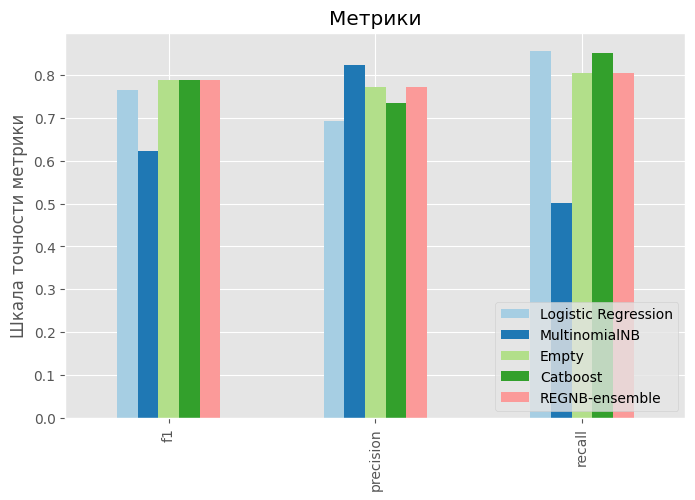

In [60]:
get_metrics()

Параметры подросли, теперь, в среднем, ансамбль показывает лучшие результаты по трем метрикам. К тому же, зная вероятности, мы можем оперировать эти данные. Например, если вероятность токсичности составляет хотя бы 20%, то для детского паблика лучше сразу прятать подобные сообщения. На игровых площадках можно поднять его до 70%, фраза необязательно была оскорбительной, так фразу "Yeah, you son of the bitch" может звучать как похвала (особенно в шутерах)

## Catboost <a class="anchor" id="boost"></a>

Кэтбуст нарекали убийцей NLP, проверим на практике. Будем использовать исходные датасеты, до обращения в разреженные матрицы

In [53]:
def cboost(X, y, Xv, yv, n_trials=10):
    
    #обозначим колонку с текстом
    text_features = ['text']
    #инструкция рекомендует использовать объект Pool
    learn_pool = catboost.Pool(X, y, text_features=text_features)
    test_pool = catboost.Pool(Xv, yv, text_features=text_features)

    
    def objective(trial):
        
        #подбираем гиперпараметры, а точнее их априорное распределение
        params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 3, step=0.1),
        'depth': trial.suggest_int('depth', 3, 8, step=1)
        }
        #также добавим вес, отправим на GPU и будем замерять F1
        #feature_calcers - максимальное число фич, которые генерит кэтбуст
        #с помощью мешка слова (BagOfWord)
        cboost = catboost.CatBoostClassifier(**params, class_weights=weight,
                                            task_type='GPU', random_seed=RS,
                                            eval_metric='F1',
                                            feature_calcers='BoW:top_tokens_count=10000'
                                            )
        cboost.fit(learn_pool, 
                   eval_set=test_pool, 
                   verbose=250
                    )
        return cboost.get_best_score().get('validation').get('F1')
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study 

In [54]:
#закомментил, считает около 15 минут
#catboost_model = cboost(X_train, y_train, X_valid, y_valid, 20)

In [55]:
#catboost_model.best_params
#TASK на GPU
catboost_params = {'iterations': 2200, 
                   'learning_rate': 0.41, 
                   'l2_leaf_reg': 1.0, 
                   'depth': 3,
                   'class_weights':weight,
                   'task_type':'GPU', 
                   'random_seed':RS,
                   'feature_calcers':'BoW:top_tokens_count=10000',
                   'verbose':250,
                   'eval_metric':'F1'
                  }

In [56]:
#инициализируем модель
boost_model = catboost.CatBoostClassifier(**catboost_params)
#обучаем
boost_model.fit(X_train, y_train, text_features=['text'])
#предсказываем
y_pred_boost = boost_model.predict(X_valid)

0:	learn: 0.6753317	total: 45.3ms	remaining: 1m 39s
250:	learn: 0.9168810	total: 2.56s	remaining: 19.9s
500:	learn: 0.9395485	total: 4.88s	remaining: 16.5s
750:	learn: 0.9551920	total: 7.2s	remaining: 13.9s
1000:	learn: 0.9654589	total: 9.53s	remaining: 11.4s
1250:	learn: 0.9724208	total: 11.8s	remaining: 8.97s
1500:	learn: 0.9771079	total: 14.2s	remaining: 6.62s
1750:	learn: 0.9800453	total: 16.6s	remaining: 4.25s
2000:	learn: 0.9825359	total: 18.9s	remaining: 1.88s
2199:	learn: 0.9843063	total: 20.8s	remaining: 0us


In [57]:
#замеряем
get_metric_row(y_valid, y_pred_boost, 'Catboost')

Метрика f1: 0.78882
Метрика precision: 0.73404
Метрика recall: 0.85244


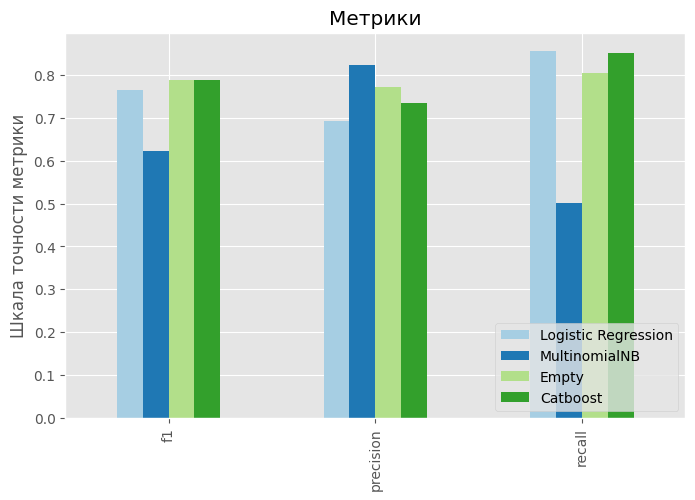

In [58]:
#и смотрим
get_metrics()

Catboost показал неплохой результат, автоматически сделав за нас часть работы. Точность чуть хуже чем у Байеса, но по совокупности факторов, а точнее по метрике F1 кэтбуст дал пока лучшие результаты. Теперь стоит попробовать то, к чему так долго шли - BERT. 

Также, стоит отметить, что градиентный бустинг долго учится, даже с учетом ГПУ (около 5-7 секунд), но моментально выдает предсказания, на уровне простых моделей.

Был также опробован BERT с дообучением с дропаутом и двумя линейными слоями с софтмаксом на выходе, но получить f1 за 4 часа - это такое себе. Поэтому переходим к тестированию лучшей модели - Catboost

## Тестирование <a class="anchor" id="test"></a>

In [62]:
final_test = boost_model.predict(X_test)

In [67]:
result_predict = f1_score(y_test, final_test)
print(f'Результат на тестовой выборке: {result_predict}')

Результат на тестовой выборке: 0.7912214842622004


In [65]:
result_predict

0.7912214842622004

Модель довольно робастна, возможно, стоило бы даже объединить три модели в единую, так можно было бы улучшить все три показателя: recall, precision и f1

In [86]:
frp, tpr, treshold = roc_curve(y_test, final_test)

In [90]:
tpr

array([0.        , 0.84672435, 1.        ])

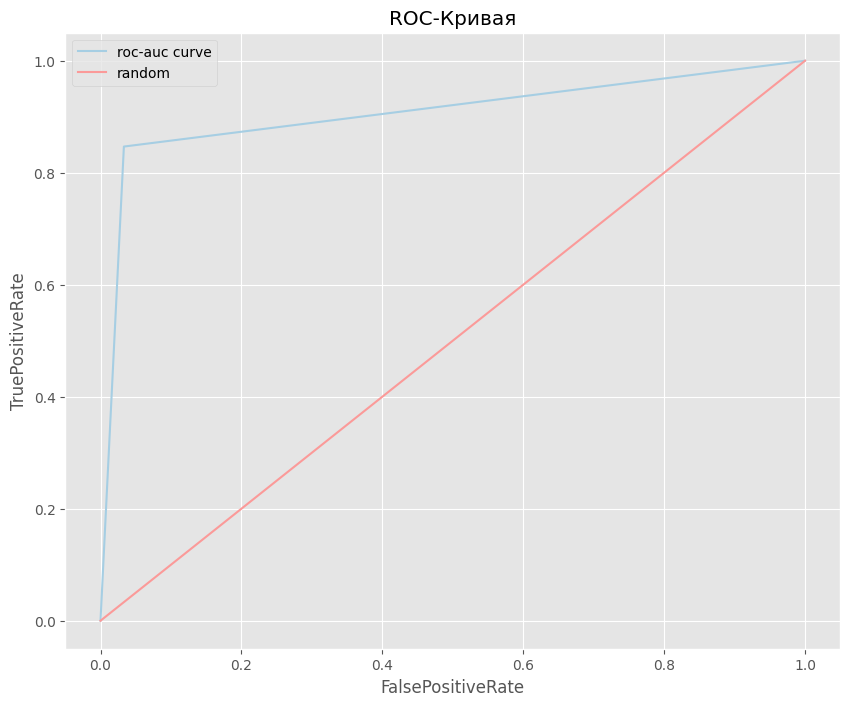

In [101]:
sns.lineplot(x=frp, y=tpr, color=color[0])
sns.lineplot(x=np.linspace(0,1,10), y=np.linspace(0,1,10), color=color[4])
plt.legend(labels=['roc-auc curve','random'])
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiveRate')
plt.title('ROC-Кривая')
plt.show()

Неплохой график, 90% процентный шанс на правильное определение почти 80% комментариев

## Заключение <a class="anchor" id="final"></a>

В данном задании мы выполнили определение токсичных комментариев, точнее, научились чистить текст и работать с лемматизатором spacy. Неплохие резлуьтаты дают не только нейронки, но и классическое машинное обучение